# 多头注意力&自注意力

多头注意力
可以使用独立学习到的h组不同的线性投影来查询、键和值

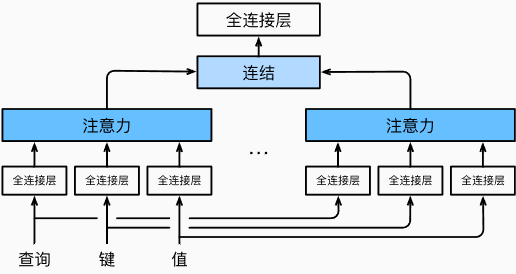

比较卷积神经网络、循环神经网络和自注意力

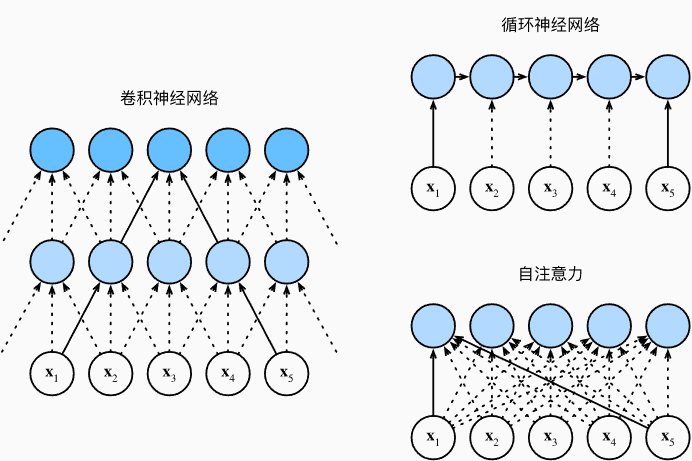

总结
- 自注意力池化层将xi当作key,value,query来对序列进行特征抽取。
- 完全并行、最长序列为1、但对于长序列计算复杂度高。
- 位置编码在输入中加入位置信息，使得自注意力能够记忆位置信息。

In [1]:
import math, torch
from torch import nn
from d2l import torch as d2l

In [2]:
#定义转置函数实现多头并行计算
#@Save
def transpose_qkv(X, num_heads):
    """变换形状使多注意力头实现并行计算"""
    #X_input_shape:(batch_size, 查询或键值对个数, num_hiddens)
    #X_output_shape:(batch_size, 查询或键值对个数, num_heads, num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    #X_output_shape:(batch_size, num_heads, 查询或键值对个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    #最终输出的形状:(batch_size*num_heads, 查询或键值对个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    #按顺序将output反推回原来X的形状
    #变换后X的形状(batch_size, num_heads, 查询或键值对个数, num_hiddens/num_heads)
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    #变换后X的形状(batch_size, 查询或键值对个数, num_heads, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    #输出X的形状(batch_size, 查询或键值对个数，num_hiddens)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [12]:
#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 num_heads, dropout, bias= False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        #单层注意力机制使用点积注意力机制
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias= bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias= bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias= bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias= bias)
    
    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            #在轴0，将第一项(标量或矢量)复制num_head次
            #然后如此重复第二项，然后诸如此类
            valid_lens = torch.repeat_interleave(valid_lens, repeats= self.num_heads, dim=0)
        
        #output的形状:(batch_size*num_heads, num_queries, num_hiddens/ num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        #output_concat的形状：(batch_size, num_queries, num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [13]:
#使用键值相同的测试用例来测试MultiHeadAttention函数
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, 
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [14]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

In [ ]:
#自注意力机制
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, 
                                   num_hiddens, num_heads, 0.5)
attention.eval()

In [ ]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

In [ ]:
#位置编码
#@save
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len= 1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        #创建P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype= torch.float32).reshape(-1, 1) / torch.pow(10000, 
        torch.arange(0, num_hiddens, 2, dtype= torch.float32) / num_hiddens )
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
    
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [ ]:
#行代表词元在序列中的位置，列代表位置编码的不同维度
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel= 'Row (position)',
         figsize= (6, 2.5), legend= ["Col %d" % d for d in torch.arange(6, 10)])

In [ ]:
for i in range(8):
    #打印前三位的二进制表示
    print(f'{i}的二进制是：{i:>03b}')

In [ ]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel= 'Column (encoding dimension)', ylabel= 'Row (position)', figsize= (3.5, 4), cmap= 'Blues')